## Data 100 Final Project - COVID19 Dataset

Aislin Liu, Anand Chandra

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap 
import seaborn as sns
from sklearn import tree
import math

Our overarching question we are hoping to model is how many days from the start of data collection (1/22/20) does it take a county to reach an established threshold of "dangerous"? We defined this "dangerous" threshold as 2% infection of the county's population.

In [2]:
april_18 = pd.read_csv("4.18states.csv")
deaths = pd.read_csv("time_series_covid19_deaths_US.csv")
deaths.shape

(3255, 100)

In [3]:
abridged_counties = pd.read_csv("abridged_couties.csv")
abridged_counties.head(30)
#Some data cleaning for abridged_counties
#What is a good value to replace NaN in this case??
#Convert the Gregorian dates to normal readable datetime format
#Columns that need this: "stay at home", ">50 gatherings", ">500 gatherings", "public schools", "restaurant dine-in", "entertainment/gym", "federal guidelines", "foreign travel ban"
#Had to write a method for this since the pd.Timestamp.fromordinal() method only takes in scalars
def ordinalToTimeStamp(series):
    arr = []
    array_form = series.values
    for o_date in array_form:
        if not math.isnan(o_date):
            arr.append(pd.Timestamp.fromordinal(int(o_date)))
        else:
            arr.append(o_date)
    return arr
gregorian = ["stay at home", ">50 gatherings", ">500 gatherings", "public schools", "restaurant dine-in", "entertainment/gym", "federal guidelines", "foreign travel ban"]
for column in gregorian:
    abridged_counties[column] = ordinalToTimeStamp(abridged_counties[column])
#Dropping some columns that I won't be basing analysis off just to have cleaner tables to look at
abridged_counties = abridged_counties.drop(["lat", "lon", "POP_LATITUDE", "POP_LONGITUDE", "CensusRegionName", "CensusDivisionName"], axis=1)
abridged_counties
print(abridged_counties.columns)
# abridged_counties["#Hospitals"].fillna(0, inplace=True)
#below are some interesting features I may want to look into
#% Uninsured
#SVIPercentile = the county's overall percentile ranking indicating the CDC's Social Vulnerability Index (SVI); higher ranking indicates greater social vulnerability

Index(['countyFIPS', 'STATEFP', 'COUNTYFP', 'CountyName', 'StateName', 'State',
       'Rural-UrbanContinuumCode2013', 'PopulationEstimate2018',
       'PopTotalMale2017', 'PopTotalFemale2017', 'FracMale2017',
       'PopulationEstimate65+2017', 'PopulationDensityperSqMile2010',
       'CensusPopulation2010', 'MedianAge2010', '#EligibleforMedicare2018',
       'MedicareEnrollment,AgedTot2017', '3-YrDiabetes2015-17',
       'DiabetesPercentage', 'HeartDiseaseMortality', 'StrokeMortality',
       'Smokers_Percentage', 'RespMortalityRate2014', '#FTEHospitalTotal2017',
       'TotalM.D.'s,TotNon-FedandFed2017', '#HospParticipatinginNetwork2017',
       '#Hospitals', '#ICU_beds', 'dem_to_rep_ratio', 'PopMale<52010',
       'PopFmle<52010', 'PopMale5-92010', 'PopFmle5-92010', 'PopMale10-142010',
       'PopFmle10-142010', 'PopMale15-192010', 'PopFmle15-192010',
       'PopMale20-242010', 'PopFmle20-242010', 'PopMale25-292010',
       'PopFmle25-292010', 'PopMale30-342010', 'PopFmle30-342010'

In the cell below, we did data cleaning for "confirmed" dataset. We removed all nulls and replaced it with appropriate values. In the "Admin2" column, nulls were replaced with empty string for when the data point had no county name stored. All areas/regions that had NaN for "FIPS" column is because they were not an actual county but still a group of people with noteworthy virus infection like correctional facilities. No actual US county has a FIPS of 0 so we filled these nulls in with 0. Also, we dropped columns we did not think we were using for analysis or as features just to have a cleaner dataframe to work with.

In [4]:
confirmed = pd.read_csv("time_series_covid19_confirmed_US.csv")
print("There are currently " + str(confirmed.isna().sum().sum()) + " NaN values in confirmed")
confirmed["Admin2"].fillna("", inplace=True)
confirmed["FIPS"].fillna(0, inplace=True)
print("There are now " + str(confirmed.isna().sum().sum()) + " NaN values in confirmed")
confirmed = confirmed.drop(["Lat", "Long_"], axis=1)
print(confirmed.columns)
confirmed.shape

There are currently 11 NaN values in confirmed
There are now 0 NaN values in confirmed
Index(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Combined_Key', '1/22/20', '1/23/20', '1/24/20',
       '1/25/20', '1/26/20', '1/27/20', '1/28/20', '1/29/20', '1/30/20',
       '1/31/20', '2/1/20', '2/2/20', '2/3/20', '2/4/20', '2/5/20', '2/6/20',
       '2/7/20', '2/8/20', '2/9/20', '2/10/20', '2/11/20', '2/12/20',
       '2/13/20', '2/14/20', '2/15/20', '2/16/20', '2/17/20', '2/18/20',
       '2/19/20', '2/20/20', '2/21/20', '2/22/20', '2/23/20', '2/24/20',
       '2/25/20', '2/26/20', '2/27/20', '2/28/20', '2/29/20', '3/1/20',
       '3/2/20', '3/3/20', '3/4/20', '3/5/20', '3/6/20', '3/7/20', '3/8/20',
       '3/9/20', '3/10/20', '3/11/20', '3/12/20', '3/13/20', '3/14/20',
       '3/15/20', '3/16/20', '3/17/20', '3/18/20', '3/19/20', '3/20/20',
       '3/21/20', '3/22/20', '3/23/20', '3/24/20', '3/25/20', '3/26/20',
       '3/27/20', '3/28/20', '

(3255, 97)

We want to answer the question: In how many days will each county reach "dangerous threshold"? (but also how do we define dangerous threshold). Let's also look at the ones that are most dangerous and identify features amongst those counties to understand which features are most critical to influencing COVID-19 spread. Can ask, did social distancing have a positive effect on number of confirmed cases? MORE NOTES TO SELF: decision tree is based on features, so what features do you plan to use and select? Y = how many days threshold reached starting from 1/22/20?, features can include current. 

In [5]:
#Code that constructs an array 'days' that holds all the days we are tracking over
#Done for simplicity purposes to iterate through the dataframe from each day
days = []
month = 1
day = 22
while month <= 4:
    if month == 1 and day == 32:
        month = 2
        day = 1
        continue
    elif month == 2 and day == 30:
        month = 3
        day = 1
        continue
    elif month == 3 and day == 32:
        month = 4
        day = 1
        continue
    elif month == 4 and day == 19:
        break
    else:
        date = str(month) + "/" + str(day) + "/20"
        days.append(date)
        day += 1

In [6]:
county_cases = confirmed.join(abridged_counties, how="left", on="FIPS")
county_cases
days_to_surpass = []
threshold = .02
for i in range(county_cases.shape[0]):
    row = county_cases.iloc[i]
    for j in range(len(days)):
        day = days[j]
        proportion = row[day] / row["PopulationEstimate2018"]
        if proportion > threshold:
            days_to_surpass.append(j)
            break
        elif j == len(days) - 1:
            days_to_surpass.append(j)
county_cases["days_to_surpass"] = days_to_surpass
        

In [7]:
county_cases

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Combined_Key,1/22/20,...,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,SVIPercentile,HPSAShortage,HPSAServedPop,HPSAUnderservedPop,days_to_surpass
0,16,AS,ASM,16,60.0,,American Samoa,US,"American Samoa, US",0,...,2020-03-16,2020-03-19,2020-03-28,2020-03-16,2020-03-11,0.8736,5.9300,66510.0,17779.0,87
1,316,GU,GUM,316,66.0,,Guam,US,"Guam, US",0,...,2020-03-16,2020-03-19,2020-03-28,2020-03-16,2020-03-11,0.7025,2.9900,14700.0,8980.0,87
2,580,MP,MNP,580,69.0,,Northern Mariana Islands,US,"Northern Mariana Islands, US",0,...,2020-03-19,2020-03-17,2020-03-17,2020-03-16,2020-03-11,0.4602,21.3110,16167.0,63934.0,87
3,630,PR,PRI,630,72.0,,Puerto Rico,US,"Puerto Rico, US",0,...,2020-03-19,2020-03-17,2020-03-17,2020-03-16,2020-03-11,0.1010,1.4700,0.0,5134.0,63
4,850,VI,VIR,850,78.0,,Virgin Islands,US,"Virgin Islands, US",0,...,2020-03-19,2020-03-17,2020-03-17,2020-03-16,2020-03-11,0.5548,NaN,NaN,NaN,87
5,84001001,US,USA,840,1001.0,Autauga,Alabama,US,"Autauga, Alabama, US",0,...,2020-03-16,2020-03-16,2020-03-18,2020-03-16,2020-03-11,0.8220,NaN,NaN,NaN,87
6,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,"Baldwin, Alabama, US",0,...,2020-03-16,2020-03-16,2020-03-18,2020-03-16,2020-03-11,0.1385,NaN,NaN,NaN,87
7,84001005,US,USA,840,1005.0,Barbour,Alabama,US,"Barbour, Alabama, US",0,...,2020-03-16,2020-03-16,2020-03-18,2020-03-16,2020-03-11,0.4981,1.6200,60.0,4864.0,87
8,84001007,US,USA,840,1007.0,Bibb,Alabama,US,"Bibb, Alabama, US",0,...,2020-03-16,2020-03-16,2020-03-18,2020-03-16,2020-03-11,0.2188,NaN,NaN,NaN,87
9,84001009,US,USA,840,1009.0,Blount,Alabama,US,"Blount, Alabama, US",0,...,2020-03-16,2020-03-16,2020-03-18,2020-03-16,2020-03-11,0.8904,NaN,NaN,NaN,87


In [43]:
confirmed

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Combined_Key,1/22/20,...,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20
0,16,AS,ASM,16,60.0,,American Samoa,US,"American Samoa, US",0,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,,Guam,US,"Guam, US",0,...,128,130,133,133,133,133,135,135,136,136
2,580,MP,MNP,580,69.0,,Northern Mariana Islands,US,"Northern Mariana Islands, US",0,...,11,11,11,11,11,11,13,13,13,14
3,630,PR,PRI,630,72.0,,Puerto Rico,US,"Puerto Rico, US",0,...,683,725,788,897,903,923,974,1043,1068,1118
4,850,VI,VIR,850,78.0,,Virgin Islands,US,"Virgin Islands, US",0,...,45,50,51,51,51,51,51,51,51,53
5,84001001,US,USA,840,1001.0,Autauga,Alabama,US,"Autauga, Alabama, US",0,...,15,17,19,19,19,23,24,26,26,25
6,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,"Baldwin, Alabama, US",0,...,56,59,66,71,72,87,91,101,103,109
7,84001005,US,USA,840,1005.0,Barbour,Alabama,US,"Barbour, Alabama, US",0,...,4,9,9,10,10,11,12,14,15,18
8,84001007,US,USA,840,1007.0,Bibb,Alabama,US,"Bibb, Alabama, US",0,...,9,11,13,16,17,17,18,22,24,26
9,84001009,US,USA,840,1009.0,Blount,Alabama,US,"Blount, Alabama, US",0,...,11,12,12,13,14,16,17,18,20,20


In [42]:
populations = confirmed.drop(['iso2', 'iso3', 'code3', 'FIPS', 'Province_State', 'Admin2', 'Country_Region', 'Combined_Key'], axis='columns')
dates = populations.columns[1:]
populations = populations.melt(id_vars=['UID'])
populations = populations.loc[populations['value'] != 0]
# sns.barplot(x='variable', y='value', hue='UID', data=populations.head(1000))
populations.loc[populations['UID'] == 84090036]

,UID,variable,value
172493,84090036,3/14/20,25
188768,84090036,3/19/20,18
192023,84090036,3/20/20,449
198533,84090036,3/22/20,23
201788,84090036,3/23/20,107


In [44]:
abridged_counties

,countyFIPS,STATEFP,COUNTYFP,CountyName,StateName,State,Rural-UrbanContinuumCode2013,PopulationEstimate2018,PopTotalMale2017,PopTotalFemale2017,...,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,SVIPercentile,HPSAShortage,HPSAServedPop,HPSAUnderservedPop
0,01001,1.0,1.0,Autauga,AL,Alabama,2.0,55601.0,27007.0,28497.0,...,2020-03-13,2020-03-16,2020-03-19,2020-03-28,2020-03-16,2020-03-11,0.4354,NaN,NaN,NaN
1,01003,1.0,3.0,Baldwin,AL,Alabama,3.0,218022.0,103225.0,109403.0,...,2020-03-13,2020-03-16,2020-03-19,2020-03-28,2020-03-16,2020-03-11,0.2162,NaN,NaN,NaN
2,01005,1.0,5.0,Barbour,AL,Alabama,6.0,24881.0,13335.0,11935.0,...,2020-03-13,2020-03-16,2020-03-19,2020-03-28,2020-03-16,2020-03-11,0.9959,6.0800,5400.0,18241.0
3,01007,1.0,7.0,Bibb,AL,Alabama,1.0,22400.0,12138.0,10530.0,...,2020-03-13,2020-03-16,2020-03-19,2020-03-28,2020-03-16,2020-03-11,0.6003,2.7500,14980.0,6120.0
4,01009,1.0,9.0,Blount,AL,Alabama,1.0,57840.0,28607.0,29406.0,...,2020-03-13,2020-03-16,2020-03-19,2020-03-28,2020-03-16,2020-03-11,0.4242,7.2100,31850.0,25233.0
5,01011,1.0,11.0,Bullock,AL,Alabama,6.0,10138.0,5615.0,4694.0,...,2020-03-13,2020-03-16,2020-03-19,2020-03-28,2020-03-16,2020-03-11,0.8898,2.3800,3000.0,7153.0
6,01013,1.0,13.0,Butler,AL,Alabama,6.0,19680.0,9232.0,10593.0,...,2020-03-13,2020-03-16,2020-03-19,2020-03-28,2020-03-16,2020-03-11,0.8653,1.3100,16290.0,3918.0
7,01015,1.0,15.0,Calhoun,AL,Alabama,3.0,114277.0,55149.0,59579.0,...,2020-03-13,2020-03-16,2020-03-19,2020-03-28,2020-03-16,2020-03-11,0.8252,4.2400,35160.0,12712.0
8,01017,1.0,17.0,Chambers,AL,Alabama,6.0,33615.0,16140.0,17573.0,...,2020-03-13,2020-03-16,2020-03-19,2020-03-28,2020-03-16,2020-03-11,0.7382,NaN,NaN,NaN
9,01019,1.0,19.0,Cherokee,AL,Alabama,6.0,26032.0,12846.0,13011.0,...,2020-03-13,2020-03-16,2020-03-19,2020-03-28,2020-03-16,2020-03-11,0.4516,2.7500,15855.0,9610.0


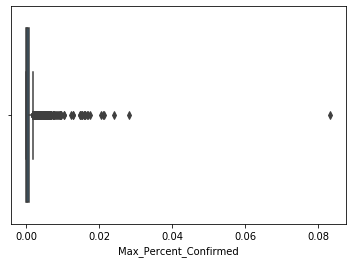

In [111]:
population_estimates = abridged_counties[['countyFIPS', 'PopulationEstimate2018']]
confirmed_modified = confirmed.drop(['iso2', 'iso3', 'code3', 'FIPS', 'Province_State', 'Country_Region', 'Combined_Key'], axis='columns')
confirmed_modified = confirmed_modified[confirmed_modified['Admin2'] != '']
confirmed_modified = confirmed_modified[confirmed_modified['Admin2'] != 'Unassigned']
find_max = confirmed_modified.drop(['Admin2'], axis='columns')
find_max = find_max.set_index('UID')
max_vals = find_max.max(axis=1).to_frame()
max_vals
confirmed
confirmed_for_thresholds = confirmed[['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Combined_Key']].rename(columns={'FIPS': 'countyFIPS'})
confirmed_for_thresholds['countyFIPS'] = confirmed_for_thresholds['countyFIPS'].astype('int64').astype('str')
thresholds = confirmed_for_thresholds.merge(population_estimates, on='countyFIPS').dropna()
thresholds = thresholds.merge(max_vals, on='UID')
thresholds = thresholds.rename(columns={0: 'Max_Confirmed'})
thresholds['Max_Percent_Confirmed'] = thresholds['Max_Confirmed'] / thresholds['PopulationEstimate2018']
sns.boxplot(x=thresholds['Max_Percent_Confirmed'])